### INLP-ES

In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

#import warnings
#warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22536\3807002410.py:27: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  plt.savefig("embeddings.{}.png".format(title), dpi=600)
  plt.show()
  return vecs_2d

In [3]:
def tsne(vecs, labels, title="", ind2label=None, words=None, metric="l2", manual_direction=None, emphasize_factor=1.0):
    """
    Apply t-SNE dimensionality reduction with emphasis on the grammatical gender direction.
    
    :param vecs: List of vectors to reduce.
    :param labels: Labels corresponding to the vectors.
    :param title: Title for the plot.
    :param ind2label: Dictionary mapping label indices to label names (optional).
    :param words: List of words corresponding to the vectors (optional).
    :param metric: Metric to use for distance calculation (default: "l2").
    :param manual_direction: A vector representing a direction to emphasize (optional).
    :param emphasize_factor: Scaling factor for emphasizing the manual direction.
    :return: The 2D representations of the vectors.
    """
    vecs = np.array(vecs)
    labels = np.array(labels)

    # Emphasize manual direction
    if manual_direction is not None:
        manual_direction = np.array(manual_direction)
        manual_direction = manual_direction / np.linalg.norm(manual_direction)  # Normalize
        projection = np.dot(vecs, manual_direction)[:, np.newaxis]  # Project onto manual direction
        vecs = np.hstack((vecs, emphasize_factor * projection))  # Add as an additional feature

    # Apply t-SNE
    tsne = TSNE(n_components=2, metric=metric)
    vecs_2d = tsne.fit_transform(vecs)

    # Plot the results
    label_names = sorted(list(set(labels.tolist())))
    names = sorted(set(labels.tolist()))

    plt.figure(figsize=(6, 5))
    colors = ["red", "blue"]  # Adjust as needed for more labels
    for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha=0.3, 
                    marker="s" if i == 0 else "o")
    plt.legend(loc="upper right")
    plt.title(title)
    #plt.savefig(f"embeddings.{title}.png", dpi=600)
    plt.show()

    return vecs_2d

### Data loading & processing

In [4]:
def load_word_vectors(fname):
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = model.index_to_key  # Replace `model.vocab.keys()` with `model.index_to_key`
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:

        if w not in model:
            continue
            
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

### Load word vectors

In [5]:
# Spanish

model_esp = KeyedVectors.load('../data/embeddings/keyedvectors/model_esp.kv', mmap='r')

In [6]:
# French
FR_model = KeyedVectors.load('../data/embeddings/keyedvectors/model_fr.kv', mmap='r')

### Collect biased words

<span style="color:red">Modification to INLP: Change of the gender direction for projection<\span>

#### Spanish

In [6]:
dSem = np.loadtxt("../data/directions/dSem")

In [12]:
num_vectors_per_class = 7500

gender_direction = dSem 

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model_esp, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, model_esp), get_vectors(fem_words, model_esp)
neut_vecs = get_vectors(neut_words, model_esp)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:50])
#print("LAST MASC")
#print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:50])
#print("LAST FEM")
#print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:50])


TOP MASC
('veterano', 'visionario', 'hombre', 'tío', 'hijoputa', 'tio', 'discípulo', 'reputado', 'tiberius', 'habilidoso', 'jr', 'ávido', 'presumido', 'sabio', 'continuador', 'amigo', 'bocón', 'creador', 'estudioso', 'individuo', 'tartamudo', 'novato', 'compañero', 'muchacho', 'seguidor', 'héroe', 'chaval', 'bunk', 'escurridizo', 'cabrón', 'tramposo', 'precursor', 'cabezón', 'hermano', 'engreído', 'sucesor', 'barbudo', 'constructor', 'legendario', 'miedoso', 'murdock', 'grandote', 'pródigo', 'viejo', 'capone', 'colaborador', 'santurrón', 'compadre', 'tirador', 'conocedor')
-------------------------
TOP FEM
('tía', 'amiga', 'directora', 'querida', 'anciana', 'escritora', 'secretaria', 'profesora', 'poetisa', 'doña', 'actriz', 'superiora', 'alexandra', 'dama', 'embajadora', 'institutriz', 'tia', 'bibliotecaria', 'bailarina', 'criada', 'socióloga', 'solterona', 'pintora', 'historiadora', 'asistenta', 'soltera', 'entrenadora', 'nacida', 'condesa', 'sirvienta', 'mentora', 'antropóloga', 'mo

#### French

In [7]:
FR_dSem = np.loadtxt("../data/directions/FR_dSem")

In [8]:
num_vectors_per_class = 7500

gender_direction = FR_dSem 

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, FR_model, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, FR_model), get_vectors(fem_words, FR_model)
neut_vecs = get_vectors(neut_words, FR_model)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:50])
#print("LAST MASC")
#print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:50])
#print("LAST FEM")
#print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:50])

TOP MASC
('il', 'Il', 'y', 'iI', 'qu', 'a', "S'", 'on', ',', "s'", "n'", 'ya', '1.Il', 'iol', 'IL', 'ce', 'où', 'Iil', "y'", ',il', ".S'", 'ça', 'On', 'Là', '1-Il', '8.Il', 'Ce', 'a.Il', '7Il', 'ne', 'ça.Il', 'si', "c'", '.Il', '1Il', '9Il', "qi'", 'iIl', 'Ça', '24Il', '60Il', '2.Il', 'vu.Il', "qui'", 'çà', '38Il', '7.Il', 'là', '4.Il', 'iil')
-------------------------
TOP FEM
('Andreanne', 'lachaîne', '.Mini', 'Audrey-Laure', 'payeuse', 'Scandibérique', 'Nathanaelle', 'organi-sation', 'Bertie-Albrecht', 'Stever', 'Samuelle', 'Joseline', 'urbainDéveloppement', 'Mikaëla', 'Karolin', '1964-1989Bulletin', 'Alysée', 'extérieureArts', 'féminine-', 'Maarten.svg', 'Interlocutrice', 'Marabelle', 'rollerenligne.com', 'Maximilienne', 'TATAYETamoureux', 'Serga', 'ART-CONCEPT-COEUR', 'Cavalon', 'Anne-Céline', 'jourée', 'André-Laurent', 'Facilitatrice', 'Noëllie', 'Laurentais', 'Guyons', 'Fiodorova', 'Victorina', 'Stéphanette', 'Donatelle', 'Annaelle', 'Karolyne', 'Sénépart', 'MaïAdmin', 'monier', 

### Perform train-dev-test split

In [13]:
# Spanish

random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 10766; Dev size: 4614; Test size: 6592


In [9]:
# French

random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 11010; Dev size: 4719; Test size: 6741


### Debias

<span style="color:red">Modification to INLP: At each iteration, the grammatical gender direction is computed, and the gender direction is substituted by its semantic gender component</span>

In [10]:
from typing import List, Dict
from tqdm import tqdm
import directions

In [11]:
def get_rowspace_projection(W: np.ndarray) -> np.ndarray:
    """
    :param W: the matrix over its nullspace to project
    :return: the projection matrix over the rowspace
    """

    # W represents the gender direction
    # P_W represents a transformation matrix (rowspace projection matrix), the function defined by ProjW(x) = w, 
    #     where w is the component of vector x in the rowspace of W
    
    if np.allclose(W, 0): # numpy.allclose: Returns True if two arrays are element-wise equal
        w_basis = np.zeros_like(W.T) # numpy.ndarray.T = self.transpose
    else:
        w_basis = scipy.linalg.orth(W.T) 
        
        # orthogonal basis :
        #     scipy.linalg.orth(A) -> Construct an orthonormal basis for the range of A using SVD
        #     * orthonormal set = 
        #           * set of unit vectors that are mutually orthogonal (orthogonal set where vectors are unit vectors)
        #           * any orthogonal set is linearly independent, hence is a basis for the subspace spanned by it
        #           * given a basis of a subspace, any vector in that subspace will be a linear combination of the basis vectors
        #     * range of matrix A = 
        #           * column space (see https://www.cfm.brown.edu/people/dobrush/cs52/Mathematica/Part3/range.html#:~:text=The%20range%20(also%20called%20the,it%20as%20Range(A).)
        #           * range = the span of the column vectors of matrix A (all possible (x vector) solutions to Ax = b) -> because the columns of AT are the rows of A
        #           * the column space of a matrtix A equals the row space of its transpose matrix AT, that's why we have W.T
        #
        # so -> w_basis = an orthonormal basis for W's rowspace

    P_W = w_basis.dot(w_basis.T) 
    
    # orthogonal projection on W's rowspace :
    #    * dot product of the basis with its transpose -> see https://math.stanford.edu/~jmadnick/R3.pdf
    #    * the orthogonal projection onto W is the function given by ProjW(x) = w, where w is the component of vector x in the rowspace of W 

    return P_W

In [12]:
def get_projection_to_intersection_of_nullspaces(rowspace_projection_matrices: List[np.ndarray], input_dim: int):
    """
    Given a list of rowspace projection matrices P_R(w_1), ..., P_R(w_n),
    this function calculates the projection to the intersection of all nullspasces of the matrices w_1, ..., w_n.
    uses the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
    N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))
    :param rowspace_projection_matrices: List[np.array], a list of rowspace projections
    :param dim: input dim
    """

    I = np.eye(input_dim)
    Q = np.sum(rowspace_projection_matrices, axis = 0) # Q = P_R(w1) + P_R(w2) + ... + P_R(wn)
    P = I - get_rowspace_projection(Q) # P = N(Q) : get the nullspace

    return P

In [13]:
def get_SG_component(v, dGram):
    
    dGram_square_norm = dGram.dot(dGram) # The dot product of a vector with itself equals the square of its magnitude/length/vector norm
    unit_dGram = dGram/ dGram_square_norm # A vector divided by its norm is a unit vector (only has a direction)
    dot_prod = v.dot(dGram) # The dot product is the similarity between vectors
    dGram_component = dot_prod * unit_dGram # we remove this much (amount) in the dGram direction
    SG_component = v - dGram_component
    
    return SG_component

In [14]:
def get_debiasing_projection(gram_emb_set_f, gram_emb_set_m, classifier_class, cls_params: Dict, num_classifiers: int, input_dim: int,
                             is_autoregressive: bool,
                             min_accuracy: float, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray,
                             Y_dev: np.ndarray, by_class=False, Y_train_main=None,
                             Y_dev_main=None, dropout_rate = 0) -> np.ndarray:
    """
    :param classifiecr_class: the sklearn classifier class (SVM/Perceptron etc.)
    :param cls_params: a dictionary, containing the params for the sklearn classifier
    :param num_classifiers: number of iterations (equivalent to number of dimensions to remove)
    :param input_dim: size of input vectors
    :param is_autoregressive: whether to train the ith classiifer on the data projected to the nullsapces of w1,...,wi-1
    :param min_accuracy: above this threshold, ignore the learned classifier
    :param X_train: ndarray, training vectors
    :param Y_train: ndarray, training labels (protected attributes)
    :param X_dev: ndarray, eval vectors
    :param Y_dev: ndarray, eval labels (protected attributes)
    :param by_class: if true, at each iteration sample one main-task label, and extract the protected attribute only from vectors from this class
    :param T_train_main: ndarray, main-task train labels
    :param Y_dev_main: ndarray, main-task eval labels
    :param dropout_rate: float, default: 0 (note: not recommended to be used with autoregressive=True)
    :return: P, the debiasing projection; rowspace_projections, the list of all rowspace projection; Ws, the list of all calssifiers.
    """
    if dropout_rate > 0 and is_autoregressive:
        warnings.warn("Note: when using dropout with autoregressive training, the property w_i.dot(w_(i+1)) = 0 no longer holds.")

    I = np.eye(input_dim)

    if by_class:
        if ((Y_train_main is None) or (Y_dev_main is None)):
            raise Exception("Need main-task labels for by-class training.")
        main_task_labels = list(set(Y_train_main.tolist()))

    X_train_cp = X_train.copy()
    X_dev_cp = X_dev.copy()
    rowspace_projections = []
    Ws = []
    
    # accuracies: array with the accuracies over iterations
    accuracies = []

    pbar = tqdm(range(num_classifiers))
    for i in pbar:

        clf = classifier.SKlearnClassifier(classifier_class(**cls_params))
        dropout_scale = 1./(1 - dropout_rate + 1e-6)
        dropout_mask = (np.random.rand(*X_train.shape) < (1-dropout_rate)).astype(float) * dropout_scale


        if by_class:
            #cls = np.random.choice(Y_train_main)  # uncomment for frequency-based sampling
            cls = random.choice(main_task_labels)
            relevant_idx_train = Y_train_main == cls
            relevant_idx_dev = Y_dev_main == cls
        else:
            relevant_idx_train = np.ones(X_train_cp.shape[0], dtype=bool)
            relevant_idx_dev = np.ones(X_dev_cp.shape[0], dtype=bool)

        acc = clf.train_network((X_train_cp * dropout_mask)[relevant_idx_train], Y_train[relevant_idx_train], X_dev_cp[relevant_idx_dev], Y_dev[relevant_idx_dev])
        
        # Printing the accuracy of the iteration
        pbar.set_description("iteration: {}, accuracy: {}".format(i, acc))
        print("\r", end="")
        
        accuracies.append(acc)
        
        if acc < min_accuracy: continue

        W = clf.get_weights()

        #---------------------------------------------------------------------------------------------------
        # Modification: removing the grammatical gender component (getting the semantic gender component)
        
        dGram = directions.get_gender_direction_LDA_emb(gram_emb_set_f, gram_emb_set_m)
        w1 = get_SG_component(W[0], dGram)
        w2 = get_SG_component(W[1], dGram)
        w3 = get_SG_component(W[2], dGram)
        W = np.array([w1,w2,w3])
        #---------------------------------------------------------------------------------------------------
        
        Ws.append(W)
        P_rowspace_wi = get_rowspace_projection(W) # projection to W's rowspace
        rowspace_projections.append(P_rowspace_wi)

        if is_autoregressive:

            """
            to ensure numerical stability, explicitly project to the intersection of the nullspaces found so far (instaed of doing X = P_iX,
            which is problematic when w_i is not exactly orthogonal to w_i-1,...,w1, due to e.g inexact argmin calculation).
            """
            # use the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
            # N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))

            P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
            # project

            X_train_cp = (P.dot(X_train.T)).T
            X_dev_cp = (P.dot(X_dev.T)).T
            #-------------------------------------------
            gram_emb_set_f = (P.dot(gram_emb_set_f.T)).T
            gram_emb_set_m = (P.dot(gram_emb_set_m.T)).T
            #-------------------------------------------

    """
    calculate final projection matrix P=PnPn-1....P2P1
    since w_i.dot(w_i-1) = 0, P2P1 = I - P1 - P2 (proof in the paper); this is more stable.
    by induction, PnPn-1....P2P1 = I - (P1+..+PN). We will use instead Ben-Israel's formula to increase stability and also generalize to the non-orthogonal case (e.g. with dropout),
    i.e., we explicitly project to intersection of all nullspaces (this is not critical at this point; I-(P1+...+PN) is roughly as accurate as this provided no dropout & regularization)
    """

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P, rowspace_projections, Ws, accuracies

#### Spanish

In [23]:
m_words = []
f_words = []

gram_emb_set_m = []
gram_emb_set_f = []
    
with open("../data/sets_palabras/ES/gram/ES_gram_LDA_m.txt", "r", encoding="utf-8") as f: 
    for line in f:
        word = line.strip()
    
        if word in m_words:
            continue
                
        if word not in model_esp:
            continue
                    
        m_words.append(word)
        gram_emb_set_m.append(model_esp[word])

with open("../data/sets_palabras/ES/gram/ES_gram_LDA_f.txt", "r", encoding="utf-8") as f: 
    for line in f:
        word = line.strip()
    
        if word in f_words:
            continue
                
        if word not in model_esp:
            continue        
                
        f_words.append(word)
        gram_emb_set_f.append(model_esp[word])

gram_emb_set_f = np.array(gram_emb_set_f)
gram_emb_set_m = np.array(gram_emb_set_m)
print(gram_emb_set_m.shape)
print(gram_emb_set_f.shape)

(16637, 300)
(15575, 300)


In [43]:
gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws, accuracies = get_debiasing_projection(gram_emb_set_f, gram_emb_set_m, gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 0, accuracy: 0.9930645860424794:   0%|                                               | 0/35 [00:01<?, ?it/s]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0011)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4300
Average scalar projection of masculine words onto dGram: 1.4300


iteration: 1, accuracy: 0.6946250541829215:   3%|█                                      | 1/35 [00:04<01:53,  3.34s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0010)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4398
Average scalar projection of masculine words onto dGram: 1.4398


iteration: 2, accuracy: 0.61790203727785:   6%|██▎                                      | 2/35 [00:08<01:53,  3.45s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0011)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4476
Average scalar projection of masculine words onto dGram: 1.4476


iteration: 3, accuracy: 0.5730385782401387:   9%|███▎                                   | 3/35 [00:11<01:50,  3.46s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0013)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4537
Average scalar projection of masculine words onto dGram: 1.4537


iteration: 4, accuracy: 0.5463805808409189:  11%|████▍                                  | 4/35 [00:15<01:46,  3.43s/it]

 Grammatical gender direction; LDA Accuracy: 0.9629 (+/- 0.0008)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4675
Average scalar projection of masculine words onto dGram: 1.4675


iteration: 5, accuracy: 0.5255743389683571:  14%|█████▌                                 | 5/35 [00:18<01:42,  3.42s/it]

 Grammatical gender direction; LDA Accuracy: 0.9629 (+/- 0.0011)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4784
Average scalar projection of masculine words onto dGram: 1.4784


iteration: 6, accuracy: 0.5036844386649328:  17%|██████▋                                | 6/35 [00:22<01:43,  3.58s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0010)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4923
Average scalar projection of masculine words onto dGram: 1.4923


iteration: 7, accuracy: 0.4830949284785436:  20%|███████▊                               | 7/35 [00:26<01:46,  3.79s/it]

 Grammatical gender direction; LDA Accuracy: 0.9626 (+/- 0.0012)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5053
Average scalar projection of masculine words onto dGram: 1.5053


iteration: 8, accuracy: 0.4726918075422627:  23%|████████▉                              | 8/35 [00:30<01:44,  3.88s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0011)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5162
Average scalar projection of masculine words onto dGram: 1.5162


iteration: 9, accuracy: 0.4672735153879497:  26%|██████████                             | 9/35 [00:34<01:40,  3.86s/it]

 Grammatical gender direction; LDA Accuracy: 0.9626 (+/- 0.0013)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5285
Average scalar projection of masculine words onto dGram: 1.5285


iteration: 10, accuracy: 0.46553966189856955:  29%|██████████▎                         | 10/35 [00:38<01:36,  3.88s/it]

 Grammatical gender direction; LDA Accuracy: 0.9626 (+/- 0.0015)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5416
Average scalar projection of masculine words onto dGram: 1.5416


iteration: 11, accuracy: 0.46770697876029477:  31%|███████████▎                        | 11/35 [00:42<01:32,  3.87s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0016)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5531
Average scalar projection of masculine words onto dGram: 1.5531


iteration: 12, accuracy: 0.46510619852622453:  34%|████████████▎                       | 12/35 [00:45<01:28,  3.84s/it]

 Grammatical gender direction; LDA Accuracy: 0.9624 (+/- 0.0011)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5702
Average scalar projection of masculine words onto dGram: 1.5702


iteration: 13, accuracy: 0.4679237104464673:  37%|█████████████▋                       | 13/35 [00:50<01:24,  3.83s/it]

 Grammatical gender direction; LDA Accuracy: 0.9624 (+/- 0.0011)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5813
Average scalar projection of masculine words onto dGram: 1.5813


iteration: 14, accuracy: 0.46749024707412223:  40%|██████████████▍                     | 14/35 [00:53<01:22,  3.92s/it]

 Grammatical gender direction; LDA Accuracy: 0.9626 (+/- 0.0015)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5918
Average scalar projection of masculine words onto dGram: 1.5918


iteration: 15, accuracy: 0.46423927178153446:  43%|███████████████▍                    | 15/35 [00:57<01:17,  3.89s/it]

 Grammatical gender direction; LDA Accuracy: 0.9625 (+/- 0.0014)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6018
Average scalar projection of masculine words onto dGram: 1.6018


iteration: 16, accuracy: 0.4670567837017772:  46%|████████████████▉                    | 16/35 [01:01<01:11,  3.78s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0018)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6078
Average scalar projection of masculine words onto dGram: 1.6078


iteration: 17, accuracy: 0.4635890767230169:  49%|█████████████████▉                   | 17/35 [01:04<01:07,  3.75s/it]

 Grammatical gender direction; LDA Accuracy: 0.9625 (+/- 0.0019)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6204
Average scalar projection of masculine words onto dGram: 1.6204


iteration: 18, accuracy: 0.46272214997832684:  51%|██████████████████▌                 | 18/35 [01:08<01:03,  3.74s/it]

 Grammatical gender direction; LDA Accuracy: 0.9624 (+/- 0.0016)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6289
Average scalar projection of masculine words onto dGram: 1.6289


iteration: 19, accuracy: 0.4620719549198093:  54%|████████████████████                 | 19/35 [01:12<00:59,  3.73s/it]

 Grammatical gender direction; LDA Accuracy: 0.9623 (+/- 0.0017)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6434
Average scalar projection of masculine words onto dGram: 1.6434


iteration: 20, accuracy: 0.46185522323363676:  57%|████████████████████▌               | 20/35 [01:16<00:56,  3.77s/it]

 Grammatical gender direction; LDA Accuracy: 0.9626 (+/- 0.0018)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6524
Average scalar projection of masculine words onto dGram: 1.6524


iteration: 21, accuracy: 0.46272214997832684:  60%|█████████████████████▌              | 21/35 [01:19<00:51,  3.69s/it]

 Grammatical gender direction; LDA Accuracy: 0.9622 (+/- 0.0018)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6679
Average scalar projection of masculine words onto dGram: 1.6679


iteration: 22, accuracy: 0.46077156480277415:  63%|██████████████████████▋             | 22/35 [01:22<00:46,  3.59s/it]

 Grammatical gender direction; LDA Accuracy: 0.9623 (+/- 0.0020)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6790
Average scalar projection of masculine words onto dGram: 1.6790


iteration: 23, accuracy: 0.45990463805808407:  66%|███████████████████████▋            | 23/35 [01:26<00:42,  3.58s/it]

 Grammatical gender direction; LDA Accuracy: 0.9627 (+/- 0.0015)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6878
Average scalar projection of masculine words onto dGram: 1.6878


iteration: 24, accuracy: 0.4620719549198093:  69%|█████████████████████████▎           | 24/35 [01:30<00:40,  3.68s/it]

 Grammatical gender direction; LDA Accuracy: 0.9622 (+/- 0.0013)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6991
Average scalar projection of masculine words onto dGram: 1.6991


iteration: 25, accuracy: 0.46142175986129175:  71%|█████████████████████████▋          | 25/35 [01:33<00:36,  3.63s/it]

 Grammatical gender direction; LDA Accuracy: 0.9623 (+/- 0.0013)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7092
Average scalar projection of masculine words onto dGram: 1.7092


iteration: 26, accuracy: 0.46142175986129175:  74%|██████████████████████████▋         | 26/35 [01:37<00:32,  3.56s/it]

 Grammatical gender direction; LDA Accuracy: 0.9622 (+/- 0.0013)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7239
Average scalar projection of masculine words onto dGram: 1.7239


iteration: 27, accuracy: 0.46055483311660167:  77%|███████████████████████████▊        | 27/35 [01:40<00:27,  3.49s/it]

 Grammatical gender direction; LDA Accuracy: 0.9622 (+/- 0.0013)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7320
Average scalar projection of masculine words onto dGram: 1.7320


iteration: 28, accuracy: 0.46185522323363676:  80%|████████████████████████████▊       | 28/35 [01:43<00:23,  3.42s/it]

 Grammatical gender direction; LDA Accuracy: 0.9624 (+/- 0.0016)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7448
Average scalar projection of masculine words onto dGram: 1.7448


iteration: 29, accuracy: 0.46055483311660167:  83%|█████████████████████████████▊      | 29/35 [01:47<00:20,  3.41s/it]

 Grammatical gender direction; LDA Accuracy: 0.9624 (+/- 0.0019)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7509
Average scalar projection of masculine words onto dGram: 1.7509


iteration: 30, accuracy: 0.45990463805808407:  86%|██████████████████████████████▊     | 30/35 [01:51<00:17,  3.51s/it]

 Grammatical gender direction; LDA Accuracy: 0.9612 (+/- 0.0012)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7464
Average scalar projection of masculine words onto dGram: 1.7464


iteration: 31, accuracy: 0.4592544429995665:  89%|████████████████████████████████▊    | 31/35 [01:54<00:14,  3.57s/it]

 Grammatical gender direction; LDA Accuracy: 0.9612 (+/- 0.0012)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7558
Average scalar projection of masculine words onto dGram: 1.7558


iteration: 32, accuracy: 0.4588209796272215:  91%|█████████████████████████████████▊   | 32/35 [01:58<00:10,  3.64s/it]

 Grammatical gender direction; LDA Accuracy: 0.9612 (+/- 0.0015)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7688
Average scalar projection of masculine words onto dGram: 1.7688


iteration: 33, accuracy: 0.45838751625487645:  94%|█████████████████████████████████▉  | 33/35 [02:02<00:07,  3.62s/it]

 Grammatical gender direction; LDA Accuracy: 0.9613 (+/- 0.0017)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7818
Average scalar projection of masculine words onto dGram: 1.7818


iteration: 34, accuracy: 0.4620719549198093:  97%|███████████████████████████████████▉ | 34/35 [02:05<00:03,  3.68s/it]

 Grammatical gender direction; LDA Accuracy: 0.9609 (+/- 0.0014)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7917
Average scalar projection of masculine words onto dGram: 1.7917


iteration: 34, accuracy: 0.4620719549198093: 100%|█████████████████████████████████████| 35/35 [02:08<00:00,  3.67s/it]


In [44]:
np.save("../data/projection_matrices/P.fasttext_es_inlpES.dim=300.iters=35.npy", P)

#### French

In [15]:
m_words = []
f_words = []

gram_emb_set_m = []
gram_emb_set_f = []
    
with open("../data/sets_palabras/FR/gram/FR_gram_LDA_m.txt", "r", encoding="utf-8") as f: 
    for line in f:
        word = line.strip()
    
        if word in m_words:
            continue
                
        if word not in FR_model:
            continue
                    
        m_words.append(word)
        gram_emb_set_m.append(FR_model[word])

with open("../data/sets_palabras/FR/gram/FR_gram_LDA_f.txt", "r", encoding="utf-8") as f: 
    for line in f:
        word = line.strip()
    
        if word in f_words:
            continue
                
        if word not in FR_model:
            continue        
                
        f_words.append(word)
        gram_emb_set_f.append(FR_model[word])

gram_emb_set_f = np.array(gram_emb_set_f)
gram_emb_set_m = np.array(gram_emb_set_m)
print(gram_emb_set_m.shape)
print(gram_emb_set_f.shape)

(2958, 300)
(2846, 300)


In [16]:
gender_clf = LinearSVC

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws, accuracies = get_debiasing_projection(gram_emb_set_f, gram_emb_set_m, gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 0, accuracy: 0.9862258953168044:   0%|                                               | 0/35 [00:01<?, ?it/s]

 Grammatical gender direction; LDA Accuracy: 0.9480 (+/- 0.0161)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.3495
Average scalar projection of masculine words onto dGram: 1.3495


iteration: 1, accuracy: 0.8018648018648019:   3%|█                                      | 1/35 [00:03<01:07,  1.99s/it]

 Grammatical gender direction; LDA Accuracy: 0.9485 (+/- 0.0162)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.3819
Average scalar projection of masculine words onto dGram: 1.3819


iteration: 2, accuracy: 0.7281203644840009:   6%|██▏                                    | 2/35 [00:05<01:10,  2.14s/it]

 Grammatical gender direction; LDA Accuracy: 0.9489 (+/- 0.0158)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.3897
Average scalar projection of masculine words onto dGram: 1.3897


iteration: 3, accuracy: 0.6848908667090485:   9%|███▎                                   | 3/35 [00:08<01:13,  2.30s/it]

 Grammatical gender direction; LDA Accuracy: 0.9491 (+/- 0.0154)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.3921
Average scalar projection of masculine words onto dGram: 1.3921


iteration: 4, accuracy: 0.6342445433354524:  11%|████▍                                  | 4/35 [00:10<01:13,  2.38s/it]

 Grammatical gender direction; LDA Accuracy: 0.9489 (+/- 0.0162)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4016
Average scalar projection of masculine words onto dGram: 1.4016


iteration: 5, accuracy: 0.5727908455181182:  14%|█████▌                                 | 5/35 [00:13<01:12,  2.42s/it]

 Grammatical gender direction; LDA Accuracy: 0.9489 (+/- 0.0159)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4182
Average scalar projection of masculine words onto dGram: 1.4182


iteration: 6, accuracy: 0.5196016105107014:  17%|██████▋                                | 6/35 [00:16<01:11,  2.48s/it]

 Grammatical gender direction; LDA Accuracy: 0.9494 (+/- 0.0142)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4253
Average scalar projection of masculine words onto dGram: 1.4253


iteration: 7, accuracy: 0.48929858020767114:  20%|███████▌                              | 7/35 [00:19<01:09,  2.49s/it]

 Grammatical gender direction; LDA Accuracy: 0.9487 (+/- 0.0142)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4522
Average scalar projection of masculine words onto dGram: 1.4522


iteration: 8, accuracy: 0.4551811824539097:  23%|████████▉                              | 8/35 [00:22<01:13,  2.72s/it]

 Grammatical gender direction; LDA Accuracy: 0.9492 (+/- 0.0130)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4668
Average scalar projection of masculine words onto dGram: 1.4668


iteration: 9, accuracy: 0.4484000847637211:  26%|██████████                             | 9/35 [00:25<01:12,  2.79s/it]

 Grammatical gender direction; LDA Accuracy: 0.9498 (+/- 0.0135)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4695
Average scalar projection of masculine words onto dGram: 1.4695


iteration: 10, accuracy: 0.45115490570036026:  29%|██████████▎                         | 10/35 [00:27<01:11,  2.84s/it]

 Grammatical gender direction; LDA Accuracy: 0.9492 (+/- 0.0137)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4764
Average scalar projection of masculine words onto dGram: 1.4764


iteration: 11, accuracy: 0.43483788938334395:  31%|███████████▎                        | 11/35 [00:30<01:07,  2.81s/it]

 Grammatical gender direction; LDA Accuracy: 0.9491 (+/- 0.0153)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4660
Average scalar projection of masculine words onto dGram: 1.4660


iteration: 12, accuracy: 0.4418308963763509:  34%|████████████▋                        | 12/35 [00:33<01:05,  2.83s/it]

 Grammatical gender direction; LDA Accuracy: 0.9499 (+/- 0.0159)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.4892
Average scalar projection of masculine words onto dGram: 1.4892


iteration: 13, accuracy: 0.44797626615808434:  37%|█████████████▎                      | 13/35 [00:36<01:02,  2.85s/it]

 Grammatical gender direction; LDA Accuracy: 0.9496 (+/- 0.0151)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5157
Average scalar projection of masculine words onto dGram: 1.5157


iteration: 14, accuracy: 0.44161898707353253:  40%|██████████████▍                     | 14/35 [00:39<01:00,  2.86s/it]

 Grammatical gender direction; LDA Accuracy: 0.9492 (+/- 0.0147)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5303
Average scalar projection of masculine words onto dGram: 1.5303


iteration: 15, accuracy: 0.4405594405594406:  43%|███████████████▊                     | 15/35 [00:42<00:57,  2.88s/it]

 Grammatical gender direction; LDA Accuracy: 0.9487 (+/- 0.0150)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5450
Average scalar projection of masculine words onto dGram: 1.5450


iteration: 16, accuracy: 0.43271879635516:  46%|█████████████████▊                     | 16/35 [00:44<00:53,  2.83s/it]

 Grammatical gender direction; LDA Accuracy: 0.9496 (+/- 0.0147)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5665
Average scalar projection of masculine words onto dGram: 1.5665


iteration: 17, accuracy: 0.42021614748887476:  49%|█████████████████▍                  | 17/35 [00:47<00:51,  2.84s/it]

 Grammatical gender direction; LDA Accuracy: 0.9492 (+/- 0.0139)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5927
Average scalar projection of masculine words onto dGram: 1.5927


iteration: 18, accuracy: 0.40707777071413437:  51%|██████████████████▌                 | 18/35 [00:50<00:48,  2.84s/it]

 Grammatical gender direction; LDA Accuracy: 0.9506 (+/- 0.0134)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6020
Average scalar projection of masculine words onto dGram: 1.6020


iteration: 19, accuracy: 0.3945751218478491:  54%|████████████████████                 | 19/35 [00:53<00:45,  2.84s/it]

 Grammatical gender direction; LDA Accuracy: 0.9499 (+/- 0.0131)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.5894
Average scalar projection of masculine words onto dGram: 1.5894


iteration: 20, accuracy: 0.3886416613689341:  57%|█████████████████████▏               | 20/35 [00:55<00:41,  2.78s/it]

 Grammatical gender direction; LDA Accuracy: 0.9503 (+/- 0.0142)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6218
Average scalar projection of masculine words onto dGram: 1.6218


iteration: 21, accuracy: 0.38440347531256625:  60%|█████████████████████▌              | 21/35 [00:58<00:38,  2.74s/it]

 Grammatical gender direction; LDA Accuracy: 0.9510 (+/- 0.0127)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6434
Average scalar projection of masculine words onto dGram: 1.6434


iteration: 22, accuracy: 0.3750794659885569:  63%|███████████████████████▎             | 22/35 [01:01<00:35,  2.73s/it]

 Grammatical gender direction; LDA Accuracy: 0.9498 (+/- 0.0130)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6528
Average scalar projection of masculine words onto dGram: 1.6528


iteration: 23, accuracy: 0.36406018224200043:  66%|███████████████████████▋            | 23/35 [01:03<00:32,  2.70s/it]

 Grammatical gender direction; LDA Accuracy: 0.9496 (+/- 0.0109)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6555
Average scalar projection of masculine words onto dGram: 1.6555


iteration: 24, accuracy: 0.37232464505191776:  69%|████████████████████████▋           | 24/35 [01:06<00:29,  2.69s/it]

 Grammatical gender direction; LDA Accuracy: 0.9508 (+/- 0.0121)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6681
Average scalar projection of masculine words onto dGram: 1.6681


iteration: 25, accuracy: 0.37698664971392243:  71%|█████████████████████████▋          | 25/35 [01:09<00:26,  2.67s/it]

 Grammatical gender direction; LDA Accuracy: 0.9517 (+/- 0.0113)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.6982
Average scalar projection of masculine words onto dGram: 1.6982


iteration: 26, accuracy: 0.38249629158720067:  74%|██████████████████████████▋         | 26/35 [01:11<00:23,  2.62s/it]

 Grammatical gender direction; LDA Accuracy: 0.9515 (+/- 0.0101)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7265
Average scalar projection of masculine words onto dGram: 1.7265


iteration: 27, accuracy: 0.3689340962068235:  77%|████████████████████████████▌        | 27/35 [01:14<00:20,  2.61s/it]

 Grammatical gender direction; LDA Accuracy: 0.9512 (+/- 0.0104)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7554
Average scalar projection of masculine words onto dGram: 1.7554


iteration: 28, accuracy: 0.36384827293918204:  80%|████████████████████████████▊       | 28/35 [01:16<00:18,  2.59s/it]

 Grammatical gender direction; LDA Accuracy: 0.9499 (+/- 0.0105)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7779
Average scalar projection of masculine words onto dGram: 1.7779


iteration: 29, accuracy: 0.3613053613053613:  83%|██████████████████████████████▋      | 29/35 [01:19<00:15,  2.58s/it]

 Grammatical gender direction; LDA Accuracy: 0.9501 (+/- 0.0110)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.7843
Average scalar projection of masculine words onto dGram: 1.7843


iteration: 30, accuracy: 0.3604577240940877:  86%|███████████████████████████████▋     | 30/35 [01:21<00:12,  2.55s/it]

 Grammatical gender direction; LDA Accuracy: 0.9517 (+/- 0.0097)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.8081
Average scalar projection of masculine words onto dGram: 1.8081


iteration: 31, accuracy: 0.35664335664335667:  89%|███████████████████████████████▉    | 31/35 [01:23<00:10,  2.50s/it]

 Grammatical gender direction; LDA Accuracy: 0.9513 (+/- 0.0121)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.8171
Average scalar projection of masculine words onto dGram: 1.8171


iteration: 32, accuracy: 0.36766264038991314:  91%|████████████████████████████████▉   | 32/35 [01:26<00:07,  2.42s/it]

 Grammatical gender direction; LDA Accuracy: 0.9499 (+/- 0.0114)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.8250
Average scalar projection of masculine words onto dGram: 1.8250


iteration: 33, accuracy: 0.36978173341809706:  94%|█████████████████████████████████▉  | 33/35 [01:28<00:04,  2.41s/it]

 Grammatical gender direction; LDA Accuracy: 0.9505 (+/- 0.0113)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.8412
Average scalar projection of masculine words onto dGram: 1.8412


iteration: 34, accuracy: 0.37041746132655223:  97%|██████████████████████████████████▉ | 34/35 [01:30<00:02,  2.37s/it]

 Grammatical gender direction; LDA Accuracy: 0.9494 (+/- 0.0112)
______________________________________________________________________________________________
Average scalar projection of feminine words onto dGram: -1.8433
Average scalar projection of masculine words onto dGram: 1.8433


iteration: 34, accuracy: 0.37041746132655223: 100%|████████████████████████████████████| 35/35 [01:31<00:00,  2.62s/it]


In [17]:
np.save("../data/projection_matrices/P.fasttext_fr_inlpES.dim=300.iters=35.npy", P)

### Test the quality of the debiasing.

#### Perform t-sne

In [18]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

#### Spanish

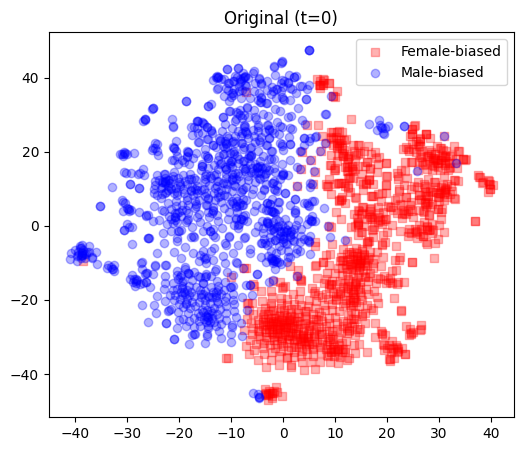

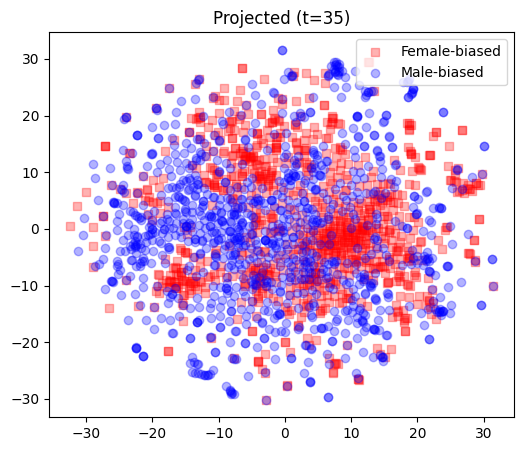

V-measure-before (TSNE space): 0.036805236764241536
V-measure-after (TSNE space): 0.016553535475708963
V-measure-before (original space): 0.9895764930730173
V-measure-after (original space): 0.004621319822758826
Rank before: 300; Rank after: 195


In [46]:
# remove neutral class, keep only male and female biased

X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M =  2000
ind2label =  {1: "Male-biased", 0: "Female-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )


X_dev_cleaned = (P.dot(X_dev.T)).T 
X_test_cleaned = (P.dot(X_test.T)).T 
X_trained_cleaned = (P.dot(X_train.T)).T 
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t={})".format(n), ind2label =ind2label )

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

#### French

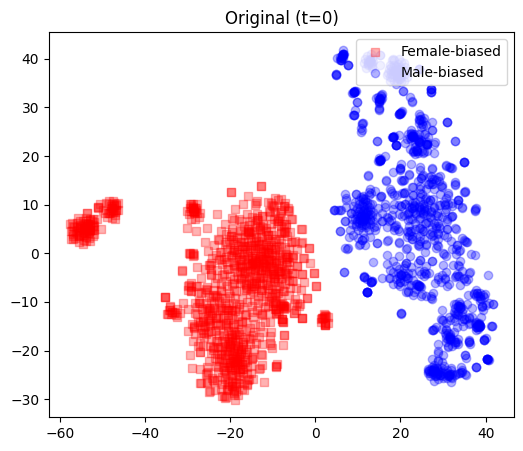

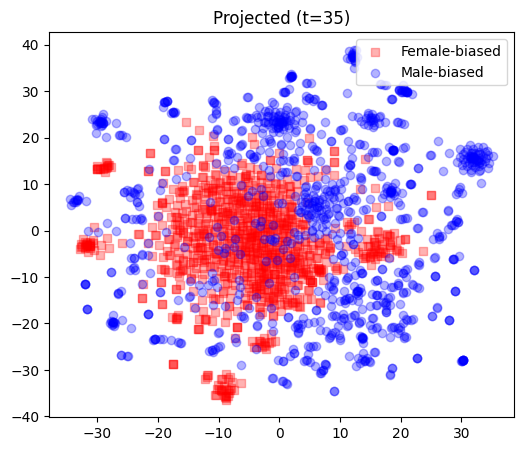

V-measure-before (TSNE space): 1.0
V-measure-after (TSNE space): 0.1334204088716866
V-measure-before (original space): 0.24106895257943875
V-measure-after (original space): 0.0010101476114288354
Rank before: 300; Rank after: 195


In [19]:
X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M =  2000
ind2label =  {1: "Male-biased", 0: "Female-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )


X_dev_cleaned = (P.dot(X_dev.T)).T 
X_test_cleaned = (P.dot(X_test.T)).T 
X_trained_cleaned = (P.dot(X_train.T)).T 
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t={})".format(n), ind2label =ind2label )

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

### Save the embeddings

#### Spanish

In [47]:
new_vectors = (P.dot(model_esp.vectors.T)).T
inlpES_debiased_model = KeyedVectors(vector_size = model_esp.vector_size)

inlpES_debiased_model.add_vectors( keys = model_esp.index_to_key
                                       , weights = new_vectors )

In [48]:
inlpES_debiased_model.save('../data/embeddings/keyedvectors/inlpES_debiased_model.kv')

#### French

In [20]:
new_vectors = (P.dot(FR_model.vectors.T)).T
FR_inlpGram_debiased_model = KeyedVectors(vector_size = FR_model.vector_size)

FR_inlpGram_debiased_model.add_vectors( keys = FR_model.index_to_key
                                       , weights = new_vectors )

In [21]:
FR_inlpGram_debiased_model.save('../data/embeddings/keyedvectors/FR_inlpGram_debiased_model.kv')

# -----------------------------------------------------------------------